#### **A natuaral language project on analyzing clinical note for automated extraction of patient's features**
<br>

##### **0) Background:**
With the work experiences in an organization providing an all-rounded rehabilitation services for the patients with disabilities and chronic diseases, there was formal documentation of clinical notes from physical therapists, occupational therapists, speech therapists, psychological therapists, and/or orthopedic practitioners in the daily operations, and occassionally when doing further analyses, a lot of information would be stored within these texts. Since the bloom of NLP models in machine learning, medical texts have been one of the most actively investigated groups in this domain. Due to the professional terms used that seldom appear in other contexts, and also a relatively loose writing styles of clinical notes or less organized grammatical structure that differentiate it from other conversations used to train standard NLP models, specific models or use cases were developed by researchers based on clinical notes or medical journals.

<br>

##### **1) Data Source:**
National Board of Medical Examiners (NBME) had launched a competition on Kaggle, which selected 10 medical cases and over 42,000 patient notes from the examination of licensed practitioners written for these 10 cases, the objective of the task was to establish an automated implementation workflow that detects the highlighted patient features from the notes, which would be scoring rubrics for evaluating if the examintaion-taker had successfully mentioned those points (Dataset descriptions: https://www.kaggle.com/competitions/nbme-score-clinical-patient-notes). Out of the examination context, more generally it could be enlarged to the problem of a word-vector-like language model to represent correlated expressions attribured to specific diagnosis or symptoms in a broader sense, but similar to the barriers of limited human efforts and time encountered in reality, annotations were made on only 100 samples per each case. 

<br>

##### **2) Model Building:**

<html>
<body>

Based on these few samples, the proposed solution to be shared as the follow is somehow like a conceptual methodology that illustrates the typical elements to work with in a standard medical text feature recognition task of this kind of NLP machine learning stream, and yet to be a matually tested scheme. The approach combines unsupervised and supervised learning:
<br>
<ul>
    <li> Stage 1:  Tokenization<br><br>
      <ul>
          <li> The annotated features might be a single word (e.g. "male") or a phrase (e.g. "family history of thyroid symptoms"), therefore word-based tokens and phrase-based tokens (noun chunks, verb phrases with objects, etc.) were separately extracted using SpaCy. </li>
          <li> The phrase-based tokenizations in SpaCy were implemented by loading a pre-trained transformer language model (RoBERTa) fitting to the texts and then extracting the noun chunks and verb-and-object phrases it has identified. RoBERTa was introduced as an enhanced version of BERT model by robustly optimizing the hyperparameters that boosted the performances in different NLP tasks compared to BERT model. </li>
      </ul>
    </li> <br>
    <li> Stage 2:  Vectorization and Dictionary Enrichments<br><br>
      <ul>
          <li> Given the limited amount of annotated words and phrases, by matching other words or phrases of high similarities using common metrics like cosine distance between the annotated and sourced token vectors, expressions of similar meanings in the texts could be added to the training set, and hence to increase the coverage and model sensitivity in capturing unseen words or phrases.
              <br>
              <br>
              <ul>
                  <li>  Level 1 would be Character Embeddings, which help recognize even if abbreviation or mis-spelling words or if a little bit different word ordering and arrangements within a phrase occurred; but since there was a risk of false identification of words of similar structure yet different semantic meanings, the similarity threshold for character embeddings was set as high as 0.9 or above. Pre-trained Char2Vec models were used for querying the embeddings, as they have advantages of learning from more language examples, which would be important for building a model that could be applicable to various semantics. <br>
                  Char2Vec:  <a href="https://github.com/IntuitionEngineeringTeam/chars2vec">https://github.com/IntuitionEngineeringTeam/chars2vec</a> </li>
               <br>
                   <li> For word-based tokens, Level 2 would be using another pre-trained word vector model, like FastText, on one hand to recognize semantically similar words, and on the other hand to screen the extracted tokens from character-level (char2vec) embeddings to ensure the precision of the matched tokens, because some tokens might be of close spelling patterns but entirelly different meanings, and hence should be discarded. For phrases, Sentence-BERT would be an alternative that decodes the relationship between texts involving arrangements of multiple words. These pre-trained models would have better detecting ability as a more general or global tool not restricted to the contexts of these 10 cases. Relatively, a slightly looser threshold range like 0.4 to 0.7 could be set as criteria of inclusion. A note on tuning this model would be the choices of thresholds, and this might depend case-by-case, some judgements should be made investigating the resulted cosine similarities of the targeted words and irrelevant words. <br>
                    FastText:  <a href="https://github.com/facebookresearch/fastText">https://github.com/facebookresearch/fastText</a> <br>
                    Sentence-BERT:  <a href="https://www.sbert.net">https://www.sbert.net</a> </li>
               <br>
                   <li> To take into account the local note features, customized training of a language model on the provided dataset might also help, however, in practical situation, this requires comparatiely vast amounts of work, because the following considerations might create drawbacks of lowering implementation efficiency:
                       <br>
                       <ul>
                            <li> annotated noun and verb phrases could be of variable lengths, there was not fixed anwser on the range of "n" for n-gram representations, when training the customized word vectors one has to tune the parameters of sliding window size and to explore different values of length "n" to come up with a reasonble binning or syntactic segmentation of the texts into phrases (e.g. "family history of thyroid symptoms" vs "thyroid symptoms"; "no cold intolerance, hair loss, or tremor" vs "hair loss, or tremor" vs "no cold intolerance" vs "hair loss" vs "tremor"), the above process would increase searching time for solving complexity; </li>
                            <li> inputs of efforts of evaluating the generated word vectors; </li>
                            <li> customized model would be less robust to unseen sentences; </li>
                       </ul>
                   </li>
                </ul>
          </li>
      </ul>
    </li> <br>
    <li>  Stage 3:  Engineering Feature Sets and Case-specific Model Training<br><br>
          <ul>
              <li> The enhanced corpus would be used for training the final products that deduce if an appeared word and phrase could be classified to one of the patient features. Since the patients had their own set of features, it would be easier to have one model assessed per each single patient. However, in practical use, a large language model would be more desirable though not to be done here due to time and resource contraints.</li>
              <li> The following steps were taken in the training process:
                  <ol>
                      <li> Take 100 bootstrap samples from tokens having cosine similarities to annotated feature expressions lower than the threshold of inclusion (i.e. irrelevant to any of the patient features) as a control class to replenish the training set </li>
                      <li> Re-balance the class ratio by oversampling the minority classes of few training samples </li>
                      <li> Combine the positive (patient feature) classes and the negative class (non-entity) </li>
                      <li> Train case-specific classifier with a feed-forward deep neural network </li>
                  </ol>
              </li>
          </ul>
    </li>
</ul>
<br>

</body>
</html>

##### **3) Implementation Pipeline:**

A simple implementation workflow could be conceptualized as:
<br>
For each patient note D: <br>
1. Repeat Stage 1 (Tokenization) to distillate word tokens and phrase tokens from new texts; <br>
2. Repeat first part of Stage 2 (Vectorization) to get representation vectors of each word token and phrase token; <br>
3. Call trained classifiers obtained from Stage 3 to identify feature-context words / phrases; <br>
4. (If necessary) Screen through and extract unseen words and phrases of high cosine similarities to the annotated expressions in the existing copus from the new texts, and add them to enhance the corpus, and perform online training or mini-batch training for updating existing models.<br>
<br>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


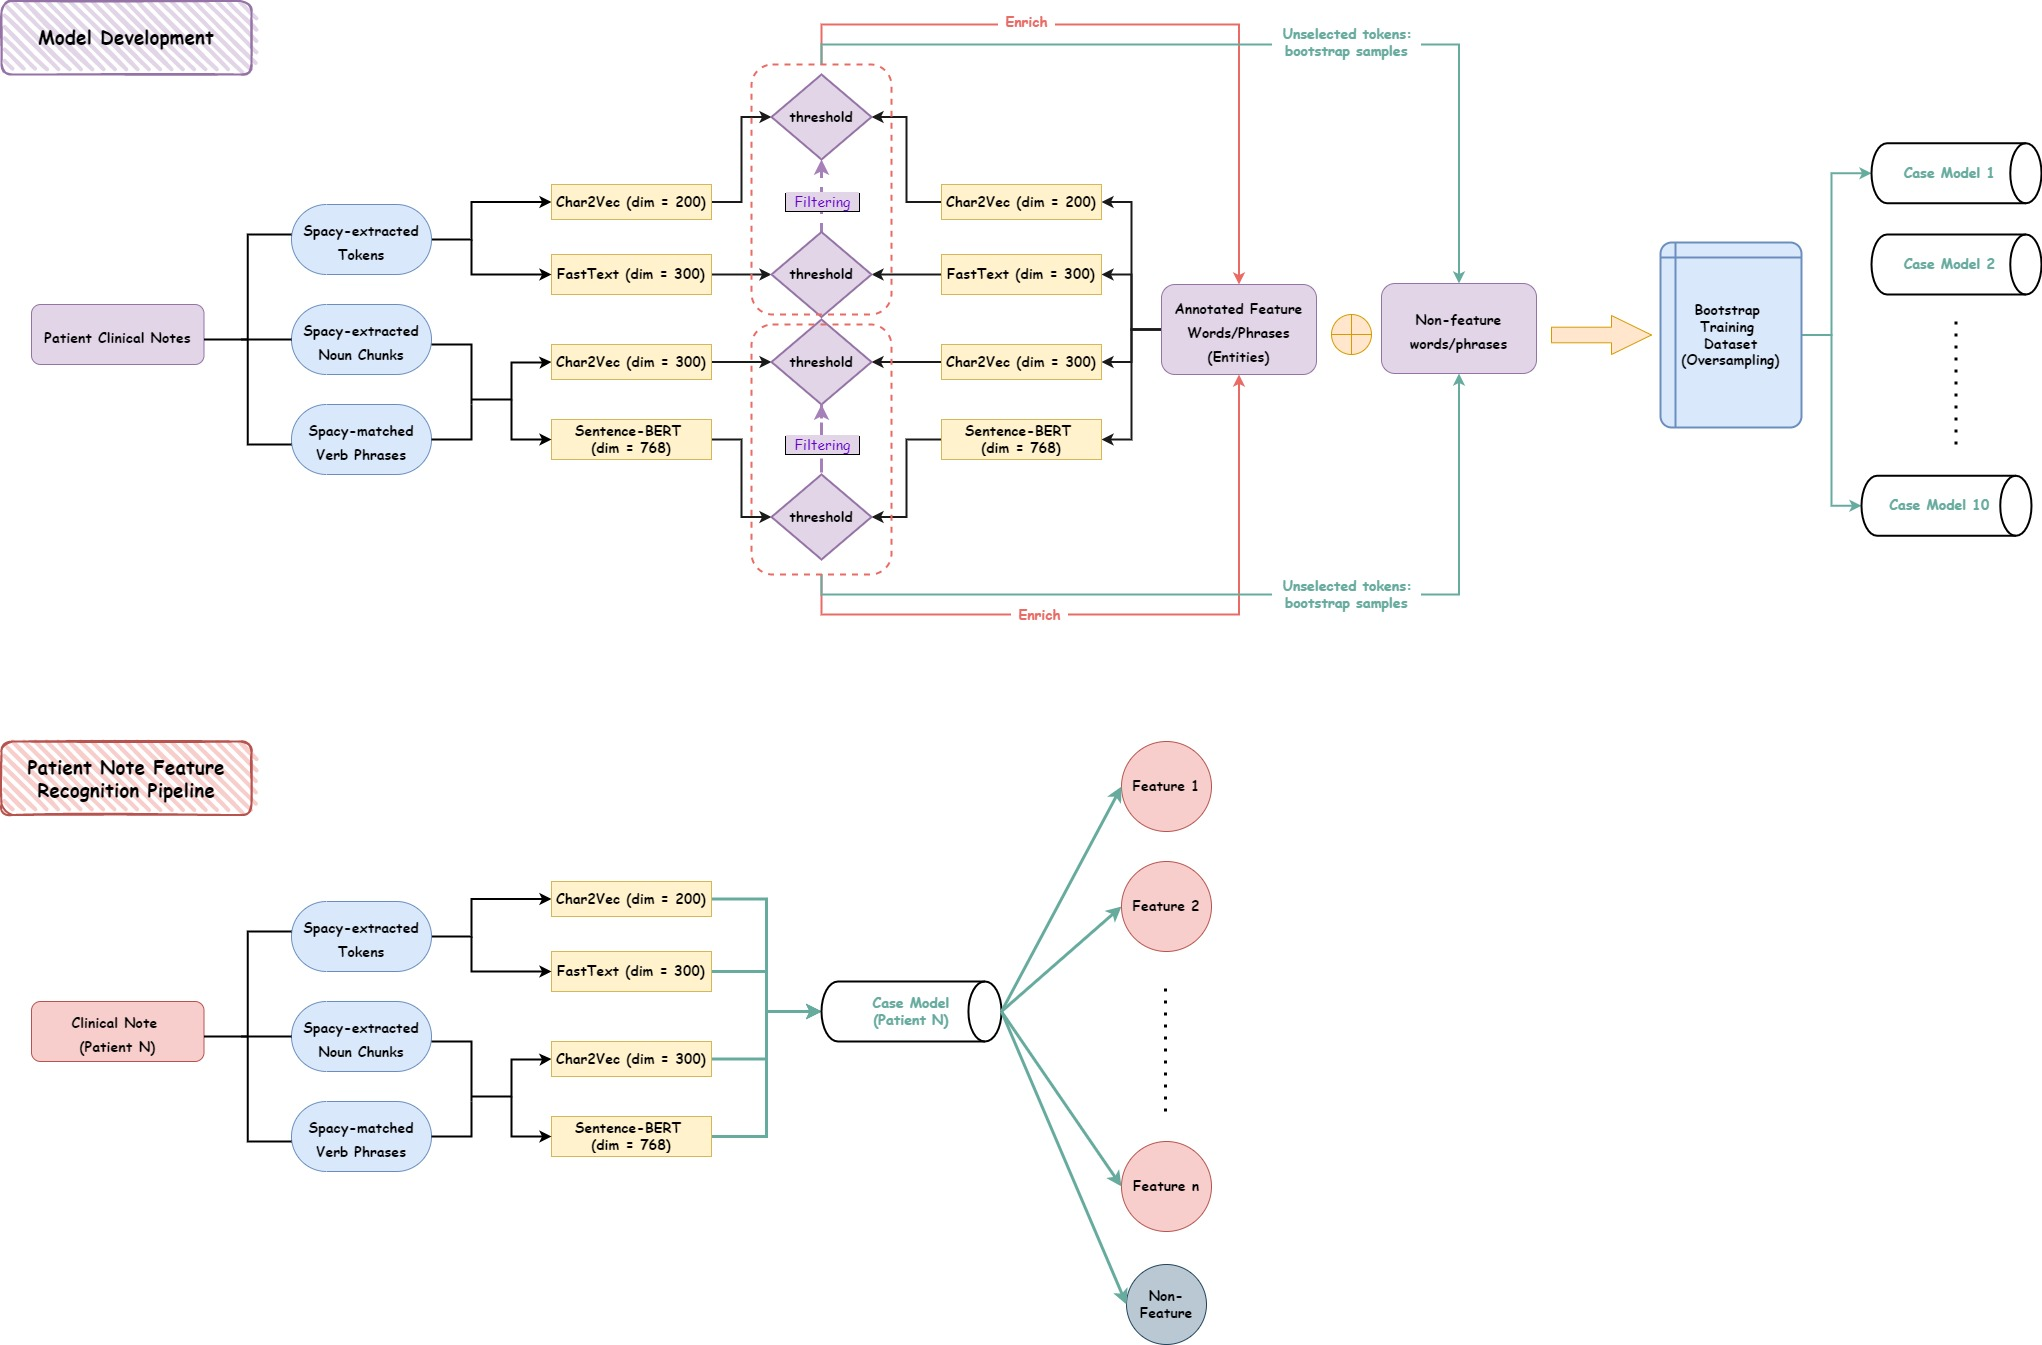

In [ ]:
from IPython.display import Image
Image(F'/content/drive/MyDrive/Colab Notebooks/NLP/clinical note/clinical_note_concepts.jpg')

In [ ]:
import os
import re
import json
import ast
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import collections
from collections import Counter

In [ ]:
import spacy
import spacy_transformers
from nltk import word_tokenize
from nltk import corpus
import nltk
import torch
from torch import nn

In [ ]:
import chars2vec
import fasttext
import fasttext.util
from sentence_transformers import SentenceTransformer

In [ ]:
## Download dataset from Kaggle
!kaggle competitions download --force -c nbme-score-clinical-patient-notes

  0% 0.00/9.83M [00:00<?, ?B/s]
100% 9.83M/9.83M [00:00<00:00, 117MB/s]


In [ ]:
!unzip nbme-score-clinical-patient-notes.zip

Archive:  nbme-score-clinical-patient-notes.zip
  inflating: features.csv            
  inflating: patient_notes.csv       
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
features = pd.read_csv("features.csv")
pntnote = pd.read_csv("patient_notes.csv")
train = pd.read_csv("train.csv")

In [ ]:
## Total number of annotated features of the 10 patients
print(features.shape)
## Total number of patient notes
print(pntnote.shape)
## Total number of annotated features (100 notes per patient)
print(train.shape)

(143, 3)
(42146, 3)
(14300, 6)


In [ ]:
## investiage features
features

feature_num  case_num                                       feature_text
0              0         0  Family-history-of-MI-OR-Family-history-of-myoc...
1              1         0                 Family-history-of-thyroid-disorder
2              2         0                                     Chest-pressure
3              3         0                              Intermittent-symptoms
4              4         0                                        Lightheaded
..           ...       ...                                                ...
138          912         9                        Family-history-of-migraines
139          913         9                                             Female
140          914         9                                        Photophobia
141          915         9                          No-known-illness-contacts
142          916         9                                   Subjective-fever

[143 rows x 3 columns]

In [ ]:
## investiagte training data
train

id  case_num  pn_num  feature_num  \
0      00016_000         0      16            0   
1      00016_001         0      16            1   
2      00016_002         0      16            2   
3      00016_003         0      16            3   
4      00016_004         0      16            4   
...          ...       ...     ...          ...   
14295  95333_912         9   95333          912   
14296  95333_913         9   95333          913   
14297  95333_914         9   95333          914   
14298  95333_915         9   95333          915   
14299  95333_916         9   95333          916   

                                     annotation              location  
0              ['dad with recent heart attcak']           ['696 724']  
1                 ['mom with "thyroid disease']           ['668 693']  
2                            ['chest pressure']           ['203 217']  
3          ['intermittent episodes', 'episode']  ['70 91', '176 183']  
4      ['felt as if he were going to pass out']           ['222 258']  
...                                         ...                   ...  
14295                                        []                    []  
14296                                        []                    []  
14297                              ['photobia']           ['274 282']  
14298                      ['no sick contacts']           ['421 437']  
14299                      ['Subjective fever']           ['314 330']  

[14300 rows x 6 columns]

In [ ]:
## investigate patient notes
pntnote[pntnote['case_num'] == 0]

pn_num  case_num                                         pn_history
0          0         0  17-year-old male, has come to the student heal...
1          1         0  17 yo male with recurrent palpitations for the...
2          2         0  Dillon Cleveland is a 17 y.o. male patient wit...
3          3         0  a 17 yo m c/o palpitation started 3 mos ago; \...
4          4         0  17yo male with no pmh here for evaluation of p...
...      ...       ...                                                ...
2263    2447         0  17 yo M comes to clinic c/o of 1st time episod...
2264    2448         0  17 yo m c/o heart pounding for the past 2-3 mo...
2265    2449         0  Pt is a 17yM with c/o Heart pounding\r\n- Onse...
2266    2450         0  17 year old male presents with heart pounding ...
2267    2451         0  CC: heart pounding\r\nHPI\r\nMr. Dillon Clevel...

[2268 rows x 3 columns]

In [ ]:
## distributions of patient note counts of the 10 cases
collections.Counter(pntnote['case_num'])

Counter({0: 2268,
         1: 808,
         2: 1958,
         3: 9753,
         4: 5405,
         5: 6909,
         6: 1597,
         7: 4101,
         8: 4196,
         9: 5151})

In [ ]:
## label the patient id for patient notes
pn_dict = {}
for idx, row in pntnote.iterrows():
    pn_dict[row['pn_num']] = row['pn_history']

## tagging tokens that exactly matching the annotated tokens
new_annotation = []
for case_id in features['case_num'].unique():

    all_pn_id = set(pntnote[pntnote['case_num']==case_id]['pn_num'].tolist())
    
    for feature_id in features[features['case_num']==case_id]['feature_num'].unique():
        # get all the pn_num that have already been annotated
        annotated_pn = set(train[train['feature_num']==feature_id]['pn_num'].tolist())
        # get all the pn_num that have NOT been annotated
        pn_to_annotate = all_pn_id - annotated_pn
        
        # get all current annotations
        # we will use them to find more annotations
        annotations = train[train['feature_num']==feature_id]['annotation'].tolist()
        annotation_texts = set()
        for a in annotations:
            anns = eval(a)
            for at in anns:
                annotation_texts.add(at)
        for pn_id in pn_to_annotate:
            new_annotation_pn, new_location_pn = [], []
            pn_text = pn_dict[pn_id]
            for at in annotation_texts:
                start = pn_text.find(at)
                if start >= 0:
                    new_annotation_pn.append(at)
                    new_location_pn.append(f'{start} {start+len(at)}')
            if len(new_annotation_pn) > 0:
                new_annotation.append((
                    f'{pn_id:04d}_{feature_id:03d}',
                    case_id,
                    pn_id,
                    feature_id,
                    new_annotation_pn,
                    new_location_pn
                ))

## new dataframe
train_exact_match = pd.DataFrame(new_annotation, columns = train.columns)
train_exact_match['id'] = train_exact_match['id'].apply(lambda x: x.split("_")[0].zfill(5) + "_" + x.split("_")[1])
features['feature_num'] = features['feature_num'].apply(lambda x: str(x).zfill(3))
train['annotation'] = train['annotation'].apply(lambda x: ast.literal_eval(x))
train['location'] = train['location'].apply(lambda x: ast.literal_eval(x))
train = pd.concat([train, train_exact_match], axis=0)
train = train.sort_values(by=['id'])
train = train.reset_index(drop=True)

train_dictionary = train[['case_num','feature_num','annotation']]
train_dictionary['annotation'] = [','.join(map(str, l)) for l in train_dictionary['annotation']]
train_dictionary_new = train_dictionary["annotation"].str.split(",", expand = True)
train_dictionary_new = pd.concat([train_dictionary_new, train_dictionary[['case_num','feature_num']]], axis=1)
train_dictionary_new = pd.melt(train_dictionary_new, id_vars=['case_num','feature_num'])
train_dictionary_new = train_dictionary_new[~pd.isnull(train_dictionary_new['value'])]
train_dictionary_new = train_dictionary_new[['case_num','feature_num','value']].\
                        sort_values(by=['case_num','feature_num']).\
                        drop_duplicates().\
                        reset_index(drop=True)
train_dictionary_new.columns = ['case_num','feature_num','annotation']

In [ ]:
train_dictionary_new

case_num  feature_num                    annotation
0            0            0                 father had MI
1            0            0                   father - MI
2            0            0                     Father MI
3            0            0                 Father had MI
4            0            0       father had heart attack
...        ...          ...                           ...
6104         9          916                      feverish
6105         9          916                feeling "warm"
6106         9          916                 Has felt warm
6107         9          916  subjective feeling of warmth
6108         9          916           feeling mildly warm

[6109 rows x 3 columns]

In [ ]:
#### Pipeline Component 1):  Patient Note Tokenization

In [ ]:
## prepare dataframes (combining feature text labels + annotated note words/phrases per each feature) for further screenings
features['feature_text'] = features['feature_text'].apply(lambda x: x.replace("-", " "))
features_token = features[~features['feature_text'].str.contains(" ")].reset_index(drop=True)
features_phrase = features[features['feature_text'].str.contains(" ")].reset_index(drop=True)
features_token.columns = ['feature_num','case_num','annotation']
features_phrase.columns = ['feature_num','case_num','annotation']

train_tokens = pd.concat([train_dictionary_new.iloc[:,1:][(~train_dictionary_new.iloc[:,1:]['annotation'].fillna('NA').str.contains(" ")) & 
                                                          (train_dictionary_new.iloc[:,1:]['annotation'].fillna('NA') != 'NA')],
                          features_token], axis = 0).reset_index(drop=True)
train_phrases = pd.concat([train_dictionary_new.iloc[:,1:][train_dictionary_new.iloc[:,1:]['annotation'].fillna('NA').str.contains(" ")],
                           features_phrase], axis = 0).reset_index(drop=True)

In [ ]:
## Tokenization:  uni-gram, noun chunks, verb phrases

def word_tokenization(notes_collection):
    stop_words = corpus.stopwords.words('english')
    token = []
    for notes in notes_collection:
        # lower-case
        notes = notes.lower()
        # substitute special characters, digits & punctuations
        notes = re.sub('\r', ' ', notes)
        notes = re.sub('\n', ' ', notes)
        notes = re.sub(r'[^a-zA-Z\s]\W+|\d+|[!?@#%^&*\[\]\\(){}<>]|[.]|[/]|[$]|[-;:,`~=_+]', ' ', notes)
        # remove leading and trailing spaces
        notes = notes.strip()
        # tokenize
        tokens = word_tokenize(notes)
        # discard stopwords
        filtered_tokens = [x for x in tokens if x not in stop_words]
        token.append(filtered_tokens)
    return token

def noun_phrase_tokenization(notes_collection):
    nlp = spacy.load('en_core_web_trf')
    token = []
    iter = 0
    for notes in notes_collection:
        notes = re.sub('\r', ' ', notes)
        notes = re.sub('\n', ' ', notes)
        notes = nlp(notes)
        phrases = set() 
        for nc in notes.noun_chunks:
            phrases.add(nc.text)
            phrases.add(notes[nc.root.left_edge.i:nc.root.right_edge.i+1].text)
        token.append(list(phrases))
        if (iter+1) % 1000 == 0:
            print("Encoded " + str(iter+1) + " notes.")
        iter += 1
    return token

def verb_noun_chunks_tokenization(notes_collection):
    nlp = spacy.load("en_core_web_trf")
    matcher = spacy.matcher.DependencyMatcher(nlp.vocab)
    pattern = [{  "RIGHT_ID": "verb",
                  "RIGHT_ATTRS": {"POS": "VERB"}
               },
               {  "LEFT_ID": "verb",
                  "REL_OP": ">>",
                  "RIGHT_ID": "object",
                  "RIGHT_ATTRS": {"DEP": "dobj"}
               }]
    matcher.add("VERB_CHUNK", [pattern])
    token = []
    iter = 0
    for notes in notes_collection:
        notes = re.sub('\r', ' ', notes)
        notes = re.sub('\n', ' ', notes)
        notes = nlp(notes)
        matches = matcher(notes)
        subtoken = []
        for match in matches:
            match_id, token_ids = match
            str_x = ""
            for r in range(token_ids[0], token_ids[len(token_ids)-1] + 1):
                str_x += " " + notes[r].text
            ms = re.match(r"(\S+ \S+)\s+(\S+)\s+", str_x.strip())
            if ms == None:
                subtoken.append(str_x.strip())
            else:
                for s in ms.groups():
                    subtoken.append(s)
        token.append(subtoken)
        if (iter+1) % 1000 == 0:
            print("Encoded " + str(iter+1) + " notes.")
        iter += 1
    return token

In [ ]:
## tokenization on words/phrases separately
pn_token = word_tokenization(pntnote['pn_history'].values.tolist())
pn_noun_phrases = noun_phrase_tokenization(pntnote['pn_history'].values.tolist())
pn_verb_obj_chunks = verb_noun_chunks_tokenization(pntnote['pn_history'].values.tolist())
pn_verb_obj_chunks_screen = []
for i in range(len(pn_verb_obj_chunks)):
    collector = []
    for j in range(len(pn_verb_obj_chunks[i])):
        if " " in pn_verb_obj_chunks[i][j]:
            collector.append(pn_verb_obj_chunks[i][j])
    pn_verb_obj_chunks_screen.append(list(set(collector)))

In [ ]:
#### Pipeline Component 2): Patient Note Vectorization

In [ ]:
## prepare unigram based embedding models
token_c2v_model = chars2vec.load_model('eng_200')
fasttext.util.download_model('en', if_exists='ignore')
ft = fasttext.load_model('cc.en.300.bin')

In [ ]:
## prepare phrase based embedding models
phrase_c2v_model = chars2vec.load_model('eng_300')
sbert_model = SentenceTransformer('all-mpnet-base-v2')

In [ ]:
## Unigram Tokens
## char2vec 200
pn_token_charVec = []
for n in range(len(pn_token)):
    pn_token_charVec.append( token_c2v_model.vectorize_words(pn_token[n]) )
## fastText 300
pn_token_ft = []
for n in range(len(pn_token_ft)):
    ft_vec = [ft.get_word_vector(x) for x in pn_token[n]]
    pn_token_ft.append(np.concatenate(ft_vec))
## Noun Chunks
## char2vec 300
pn_noun_phrases_charVec = []
for n in range(len(pn_noun_phrases)):
    pn_noun_phrases_charVec.append( c2v_model.vectorize_words(pn_noun_phrases[n]) )
## sentence-bert 768
pn_noun_phrases_BertVec = []
for n in range(len(pn_noun_phrases)):
    embeddings_for_x = sbert_model.encode(pn_noun_phrases[n])
    pn_noun_phrases_BertVec.append(embeddings_for_x)
## Verb Phrases
## char2vec 300
pn_verb_obj_chunks_screen_charVec = []
for n in range(len(pn_verb_obj_chunks_screen)):
    pn_verb_obj_chunks_screen_charVec.append( c2v_model.vectorize_words(pn_verb_obj_chunks_screen[n]) )
## sentence-bert 768
pn_verb_obj_chunks_BertVec = []
for n in range(len(pn_verb_obj_chunks_screen)):
    if len(pn_verb_obj_chunks_screen[n]) > 0:
        embeddings_for_x = sbert_model.encode(pn_verb_obj_chunks_screen[n])
        pn_verb_obj_chunks_BertVec.append(embeddings_for_x)
    else:
        pn_verb_obj_chunks_BertVec.append([])

In [ ]:
## get tokens & phrases for annotated feature labels
case_feature_tokens = []
case_features_phrases = []
for case in set(features['case_num']):
    texts = features[features['case_num'] == case]['feature_text']
    texts = texts.apply(lambda x: x.replace("-", " "))
    phrases = [x if " " in x else "" for x in texts]
    tokens = [x if " " not in x else "" for x in texts]
    case_feature_tokens.append(tokens)
    case_features_phrases.append(phrases)

In [ ]:
## get vectors for tokens & phrases for annotated feature labels

feature_name_token_char2vec = []
feature_name_token_ft = []
for n in case_feature_tokens:
    sub_token_vec = []
    sub_token_ft = []
    for w in n:
        if w != "":
            sub_token_vec.append(token_c2v_model.vectorize_words([w]))
            sub_token_bert.append(ft.get_word_vector(w))
        else:
            sub_token_vec.append(np.zeros((1,200)))
            sub_token_ft.append(np.zeros((1,300)))
    feature_name_token_char2vec.append(sub_token_vec)
    feature_name_token_ft.append(sub_token_ft)

feature_name_phrase_char2vec = []
feature_name_phrase_bert = []
for n in case_features_phrases:
    sub_phrases_vec = []
    sub_phrases_bert = []
    for ph in n:
        if ph != "":
            sub_phrases_vec.append(phrase_c2v_model.vectorize_words([ph]))
            sub_phrases_bert.append(sbert_model.encode([ph]))
        else:
            sub_phrases_vec.append(np.zeros((1,300)))
            sub_phrases_bert.append(np.zeros((1,768)))
    feature_name_phrase_char2vec.append(sub_phrases_vec)
    feature_name_phrase_bert.append(sub_phrases_bert)

In [ ]:
## embeddings encoder for annotated training data of each case
def embeddings_training_feature(train_data, case, feature):

    token_char2vec = []
    token_ft = []
    phrase_char2vec = []
    sentence_bert = []

    df = train_data[(train_data['case_num'] == case) & (train_data['feature_num'] == feature)]
    texts = df['annotation'].values.tolist()
    pn_phrases = [x for x in texts if " " in x]
    pn_tokens = [x for x in texts if " " not in x]
    pn_phrases = [x for x in pn_phrases if x.strip() != '']
    pn_tokens = [x for x in pn_tokens if x.strip() != '']

    if len(pn_tokens) > 0:
        sub_token_vec = token_c2v_model.vectorize_words(pn_tokens)
        token_char2vec.append(sub_token_vec)
        sub_ft_vec = np.concatenate([ft.get_word_vector(x) for x in pn_token[n]])
        token_ft.append(sub_ft_vec)
    else:
        token_char2vec.append(np.zeros((1, 200)))
        token_ft.append(np.zeros((1, 768)))

    if len(pn_phrases) > 0:
        sub_phrases_vec = phrase_c2v_model.vectorize_words(pn_phrases)
        phrase_char2vec.append(sub_phrases_vec)
        s_embeddings = sbert_model.encode(pn_phrases)
        sentence_bert.append(s_embeddings)
    else:
        phrase_char2vec.append(np.zeros((1,300)))
        sentence_bert.append(np.zeros((1,768)))

    return token_char2vec, token_ft, phrase_char2vec, sentence_bert

In [ ]:
train_token_char2vec = []
train_token_ft = []
train_phrase_char2vec = []
train_sentence_bert = []

for k in case_feature.keys():

    sub_train_token_char2vec = []
    sub_train_token_ft = []
    sub_train_phrase_char2vec = []
    sub_train_sentence_bert = []

    for f in case_feature[k]:
        casenum = k
        featurenum = f
        o1, o2, o3, o4 = embeddings_training_feature(train_dictionary_new, casenum, featurenum)

        sub_train_token_char2vec.append(o1)
        sub_train_token_ft.append(o2)
        sub_train_phrase_char2vec.append(o3)
        sub_train_sentence_bert.append(o4)

        print("Completed : " + "case " + str(k) + " feature " + str(f))

    train_token_char2vec.append(sub_train_token_char2vec)
    train_token_ft.append(sub_train_token_ft)
    train_phrase_char2vec.append(sub_train_phrase_char2vec)
    train_sentence_bert.append(sub_train_sentence_bert)

Completed : case 0 feature 0
Completed : case 0 feature 1
Completed : case 0 feature 2
Completed : case 0 feature 3
Completed : case 0 feature 4
Completed : case 0 feature 5
Completed : case 0 feature 6
Completed : case 0 feature 7
Completed : case 0 feature 8
Completed : case 0 feature 9
Completed : case 0 feature 10
Completed : case 0 feature 11
Completed : case 0 feature 12
Completed : case 1 feature 100
Completed : case 1 feature 101
Completed : case 1 feature 102
Completed : case 1 feature 103
Completed : case 1 feature 104
Completed : case 1 feature 105
Completed : case 1 feature 106
Completed : case 1 feature 107
Completed : case 1 feature 108
Completed : case 1 feature 109
Completed : case 1 feature 110
Completed : case 1 feature 111
Completed : case 1 feature 112
Completed : case 2 feature 200
Completed : case 2 feature 201
Completed : case 2 feature 202
Completed : case 2 feature 203
Completed : case 2 feature 204
Completed : case 2 feature 205
Completed : case 2 feature 206


In [ ]:
#### Pipeline Component 3): Corpus Enhancements (Addition of high-similarity tokens)

In [ ]:
## Comparing cosine similarities between the embeddings of tokens from un-annotated patient notes and embeddings of annotated tokens
## Enhance the training corpus by adding similar words with high cosine similarities on feature vectors

def token_c2v_similarity(source_feature, source_train, target, pn_token, threshold, case_num):

    target = [target[x] for x in pntnote[pntnote['case_num'] == case_num].index.tolist()]
    target_idx = [x for x in pntnote[pntnote['case_num'] == case_num].index.tolist()]
    source_feature = source_feature[case_num]
    source_train = source_train[case_num]
    select_token = []
    select_token_vec = []
    feature_num_add = []
    for n in range(len(target)):
        for m in range(len(target[n])):
            cos_sim = [cosine_similarity(target[n][m].reshape(1,200), x) if np.sum(x) > 0 else 0 for x in source_feature]
            cos_sim_idx = [i for i in range(len(cos_sim)) if cos_sim[i] > threshold]
            if len(cos_sim_idx) > 0:
                for c in cos_sim_idx:
                    feature_num_add.append(c)
                    select_token.append(pn_token[target_idx[n]][m])
                    select_token_vec.append(target[n][m])
            for f in range(len(source_train)):
                cos_sim = [cosine_similarity(target[n][m].reshape(1,200), y.reshape(1,200)) if np.sum(y) > 0 else 0 for y in source_train[f][0]]
                cos_sim_idx = [i for i in range(len(cos_sim)) if cos_sim[i] > threshold]
                if len(cos_sim_idx) > 0:
                    feature_num_add.append(f)
                    select_token.append(pn_token[target_idx[n]][m])
                    select_token_vec.append(target[n][m])

    return select_token, select_token_vec, feature_num_add

def token_ft_similarity(source_feature, source_train, target, pn_token, threshold, case_num):

    target = [target[x] for x in pntnote[pntnote['case_num'] == case_num].index.tolist()]
    target_idx = [x for x in pntnote[pntnote['case_num'] == case_num].index.tolist()]
    source_feature = source_feature[case_num]
    source_train = source_train[case_num]
    select_token = []
    select_token_vec = []
    feature_num_add = []
    for n in range(len(target)):
        for m in range(len(target[n])):
            cos_sim = [cosine_similarity(target[n][m].reshape(1,300), x) if np.sum(x) > 0 else 0 for x in source_feature]
            cos_sim_idx = [i for i in range(len(cos_sim)) if cos_sim[i] > threshold]
            if len(cos_sim_idx) > 0:
                for c in cos_sim_idx:
                    feature_num_add.append(c)
                    select_token.append(pn_token[target_idx[n]][m])
                    select_token_vec.append(target[n][m])
            for f in range(len(source_train)):
                cos_sim = [cosine_similarity(target[n][m].reshape(1,300), y.reshape(1,300)) if np.sum(y) > 0 else 0 for y in source_train[f][0]]
                cos_sim_idx = [i for i in range(len(cos_sim)) if cos_sim[i] > threshold]
                if len(cos_sim_idx) > 0:
                    feature_num_add.append(f)
                    select_token.append(pn_token[target_idx[n]][m])
                    select_token_vec.append(target[n][m])

    return select_token, select_token_vec, feature_num_add

def phrase_c2v_similarity(source_feature, source_train, target, pn_phrase, threshold, case_num):

    target = [target[x] for x in pntnote[pntnote['case_num'] == case_num].index.tolist()]
    target_idx = [x for x in pntnote[pntnote['case_num'] == case_num].index.tolist()]
    source_feature = source_feature[case_num]
    source_train = source_train[case_num]
    select_phrase = []
    select_phrase_vec = []
    feature_num_add = []
    for n in range(len(target)):
        for m in range(len(target[n])):
            cos_sim = [cosine_similarity(target[n][m].reshape(1,300), x) if np.sum(x) > 0 else 0 for x in source_feature]
            cos_sim_idx = [i for i in range(len(cos_sim)) if cos_sim[i] > threshold]
            if len(cos_sim_idx) > 0:
                for c in cos_sim_idx:
                    feature_num_add.append(c)
                    select_phrase.append(pn_phrase[target_idx[n]][m])
                    select_phrase_vec.append(target[n][m])
            for f in range(len(source_train)):
                cos_sim = [cosine_similarity(target[n][m].reshape(1,300), y.reshape(1,300)) if np.sum(y) > 0 else 0 for y in source_train[f][0]]
                cos_sim_idx = [i for i in range(len(cos_sim)) if cos_sim[i] > threshold]
                if len(cos_sim_idx) > 0:
                    feature_num_add.append(f)
                    select_phrase.append(pn_phrase[target_idx[n]][m])
                    select_phrase_vec.append(target[n][m])

    return select_phrase, select_phrase_vec, feature_num_add

def bert_phrase_similarity(source_feature, source_train, target, pn_phrase, threshold, case_num):

    target = [target[x] for x in pntnote[pntnote['case_num'] == case_num].index.tolist()]
    target_idx = [x for x in pntnote[pntnote['case_num'] == case_num].index.tolist()]
    source_feature = source_feature[case_num]
    source_train = source_train[case_num]
    select_phrase = []
    select_phrase_vec = []
    feature_num_add = []
    for n in range(len(target)):
        for m in range(len(target[n])):
            cos_sim = [cosine_similarity(target[n][m].reshape(1,768), x.reshape(1,768)) if np.sum(x) > 0 else 0 for x in source_feature]
            cos_sim_idx = [i for i in range(len(cos_sim)) if cos_sim[i] > threshold]
            if len(cos_sim_idx) > 0:
                for c in cos_sim_idx:
                    feature_num_add.append(c)
                    select_phrase.append(pn_phrase[target_idx[n]][m])
                    select_phrase_vec.append(target[n][m])
            for f in range(len(source_train)):
                cos_sim = [cosine_similarity(target[n][m].reshape(1,768), y.reshape(1,768)) if np.sum(y) > 0 else 0 for y in source_train[f][0]]
                cos_sim_idx = [i for i in range(len(cos_sim)) if cos_sim[i] > threshold]
                if len(cos_sim_idx) > 0:
                    feature_num_add.append(f)
                    select_phrase.append(pn_phrase[target_idx[n]][m])
                    select_phrase_vec.append(target[n][m])

    return select_phrase, select_phrase_vec, feature_num_add

In [ ]:
## high threshold 0.9 for character-level embeddings
add_tokens = []
add_tokens_vec = []
add_tokens_feature = []
for n in range(10):
    select_token, select_token_vec, feature_num_add = token_c2v_similarity(feature_name_token_char2vec, 
                                                                           train_token_char2vec, 
                                                                           pn_token_charVec, 
                                                                           pn_token, 0.9, n)
    add_tokens.append(select_token)
    add_tokens_vec.append(select_token_vec)
    add_tokens_feature.append(feature_num_add)

In [ ]:
## screen char2vec results with fasttext
token_case_dfs = []

for c in range(len(add_tokens)):
    case_df = pd.DataFrame({'add_tokens': add_tokens[c], 'features': add_tokens_feature[c], 'vectors': add_tokens_vec[c]})
    case_df = case_df.groupby(['add_tokens','features']).agg({'vectors': 'first'}).reset_index()

    case_dfs_sim = []
    for r in range(case_df.shape[0]):
        fn = case_df['features'].iloc[r]
        ref = train_tokens[(train_tokens['case_num'] == c) & (train_tokens['feature_num'] == fn)]
        ft_target = ft.get_word_vector(case_df['add_tokens'].iloc[r])
        if ref.shape[0] > 0:
            fn_sim = []
            for x in range(ref.shape[0]):
                ft_ref = ft.get_word_vector(ref['annotation'].iloc[x])
                sim = cosine_similarity(ft_target.reshape(1,-1), ft_ref.reshape(1,-1))
                fn_sim.append(sim)
        else:
            fn_sim = [1,1]
        case_dfs_sim.append(max(fn_sim))
        
    case_df['cos_sim'] = case_dfs_sim
    case_df['cos_sim'] = case_df['cos_sim'].apply(lambda x: x[0][0] if isinstance(x, int) == False else x)
    case_df['case'] = c

    token_case_dfs.append(case_df)

case_dfs_tokens_char2vec = pd.concat(token_case_dfs, axis = 0)

In [ ]:
## threshold levels => 0.4
print(case_dfs_tokens_char2vec.shape)
print(case_dfs_tokens_char2vec[case_dfs_tokens_char2vec['cos_sim'] > 0.5].shape)
print(case_dfs_tokens_char2vec[case_dfs_tokens_char2vec['cos_sim'] > 0.4].shape)
print(case_dfs_tokens_char2vec[case_dfs_tokens_char2vec['cos_sim'] > 0.3].shape)
print(case_dfs_tokens_char2vec[case_dfs_tokens_char2vec['cos_sim'] > 0.2].shape)

(5008, 5)
(4666, 5)
(4726, 5)
(4819, 5)
(4919, 5)


In [ ]:
## fastText threshold 0.7 for word-level embeddings
token_case_dfs = []
for n in range(10):
    select_token, select_token_vec, feature_num_add = token_ft_similarity(feature_name_token_ft, 
                                                                          train_token_ft, 
                                                                          pn_token_ft, 
                                                                          pn_token, 0.7, n)
    case_df = pd.DataFrame({'add_tokens': select_token, 'features': feature_num_add, 'vectors': select_token_vec})
    case_df = case_df.groupby(['add_tokens','features']).agg({'vectors': 'first'}).reset_index()
    token_case_dfs.append(case_df)
case_dfs_tokens_ft = pd.concat(token_case_dfs, axis = 0)

In [ ]:
## high threshold 0.9 for character-level embeddings
add_phrase = []
add_phrase_vec = []
add_phrase_feature = []
for n in range(10):
    ## noun chunks
    select_phrase, select_phrase_vec, feature_num_add = phrase_similarity(feature_name_phrase_char2vec, 
                                                                          train_phrase_char2vec, 
                                                                          pn_noun_phrases_charVec, 
                                                                          pn_noun_phrases, 0.9, n)
    add_phrase.append(select_phrase)
    add_phrase_vec.append(select_phrase_vec)
    add_phrase_feature.append(feature_num_add)

In [ ]:
## screen char2vec results with sentence bert setting lower threshold
token_case_dfs = []

for c in range(len(add_phrases)):
    case_df = pd.DataFrame({'add_phrases': add_phrase[c], 'features': add_phrase_feature[c], 'vectors': add_phrase_vec[c]})
    case_df = case_df.groupby(['add_phrases','features']).agg({'vectors': 'first'}).reset_index()

    case_dfs_sim = []
    for n in range(len(case_df['add_phrases'])):
        sbert_sim = []
        fn = case_df['features'].iloc[n]
        ref_fn_vec = feature_name_phrase_bert[c][fn]
        ref_train_vec = train_sentence_bert[c][fn][0]
        nt_num = [x for x in range(len(pn_noun_phrases)) if case_df['add_phrases'].iloc[n] in pn_noun_phrases[x]]
        nt_pos = [[y for y in range(len(pn_noun_phrases[nt_num[x]])) 
                   if pn_noun_phrases[nt_num[x]][y] == case_df['add_phrases'].iloc[n]] for x in range(len(nt_num))]
        for x in range(len(nt_num)):
            for y in range(len(nt_pos[x])):
                ph_vec = pn_noun_phrases_BertVec[nt_num[x]][nt_pos[x][y]]
                cos_sim_fn = cosine_similarity(ph_vec.reshape(1,-1), ref_fn_vec.reshape(1,-1))
                sbert_sim.append(cos_sim_fn)
                for r in range(len(ref_train_vec)):
                    cos_sim_train = cosine_similarity(ph_vec.reshape(1,-1), ref_train_vec[r].reshape(1,-1))
                    sbert_sim.append(cos_sim_train)
        case_dfs_sim.append(max(sbert_sim))
        
    case_df['cos_sim'] = sbert_out
    case_df['cos_sim'] = case_df['cos_sim'].apply(lambda x: x[0][0] if isinstance(x, int) == False else x)
    case_df['case'] = c

    token_case_dfs.append(case_df)

train_nounphrase_case_dfs = pd.concat(token_case_dfs, axis = 0)

In [ ]:
## threshold levels => 0.6
print(train_nounphrase_case_dfs.shape)
print(train_nounphrase_case_dfs[train_nounphrase_case_dfs['cos_sim'] > 0.6].shape)
print(train_nounphrase_case_dfs[train_nounphrase_case_dfs['cos_sim'] > 0.5].shape)
print(train_nounphrase_case_dfs[train_nounphrase_case_dfs['cos_sim'] > 0.4].shape)
print(train_nounphrase_case_dfs[train_nounphrase_case_dfs['cos_sim'] > 0.3].shape)
print(train_nounphrase_case_dfs[train_nounphrase_case_dfs['cos_sim'] > 0.2].shape)

(248295, 5)
(42843, 5)
(69798, 5)
(116041, 5)
(179339, 5)
(228309, 5)


In [ ]:
## high threshold 0.9 for character-level embeddings
add_phrase = []
add_phrase_vec = []
add_phrase_feature = []
for n in range(10):
    ## verb phrases with objects
    select_phrase, select_phrase_vec, feature_num_add = phrase_similarity(feature_name_phrase_char2vec, 
                                                                          train_phrase_char2vec, 
                                                                          pn_verb_obj_chunks_screen_charVec, 
                                                                          pn_verb_obj_chunks_screen, 0.9, n)
    add_phrase.append(select_phrase)
    add_phrase_vec.append(select_phrase_vec)
    add_phrase_feature.append(feature_num_add)

In [ ]:
## screen with sentence bert setting lower threshold
token_case_dfs = []

for c in range(len(add_phrases)):
    case_df = pd.DataFrame({'add_phrases': add_phrase[c], 'features': add_phrase_feature[c], 'vectors': add_phrase_vec[c]})
    case_df = case_df.groupby(['add_phrases','features']).agg({'vectors': 'first'}).reset_index()

    case_dfs_sim = []
    for n in range(len(case_df['add_phrases'])):
        sbert_sim = []
        fn = case_df['features'].iloc[n]
        ref_fn_vec = feature_name_phrase_bert[c][fn]
        ref_train_vec = train_sentence_bert[c][fn][0]
        nt_num = [x for x in range(len(pn_verb_obj_chunks_screen)) if case_df['add_phrases'].iloc[n] in pn_verb_obj_chunks_screen[x]]
        nt_pos = [[y for y in range(len(pn_verb_obj_chunks_screen[nt_num[x]])) 
                   if pn_verb_obj_chunks_screen[nt_num[x]][y] == case_df['add_phrases'].iloc[n]] for x in range(len(nt_num))]
        for x in range(len(nt_num)):
            for y in range(len(nt_pos[x])):
                ph_vec = pn_verb_obj_chunks_BertVec[nt_num[x]][nt_pos[x][y]]
                cos_sim_fn = cosine_similarity(ph_vec.reshape(1,-1), ref_fn_vec.reshape(1,-1))
                sbert_sim.append(cos_sim_fn)
                for r in range(len(ref_train_vec)):
                    cos_sim_train = cosine_similarity(ph_vec.reshape(1,-1), ref_train_vec[r].reshape(1,-1))
                    sbert_sim.append(cos_sim_train)
        case_dfs_sim.append(max(sbert_sim))
        
    case_df['cos_sim'] = case_dfs_sim
    case_df['cos_sim'] = case_df['cos_sim'].apply(lambda x: x[0][0] if isinstance(x, int) == False else x)
    case_df['case'] = c

    token_case_dfs.append(case_df)

case_dfs_vphrases_char2vec = pd.concat(token_case_dfs, axis = 0)

In [ ]:
## threshold levels => 0.8
print(case_dfs_vphrases_char2vec.shape)
print(case_dfs_vphrases_char2vec[case_dfs_vphrases_char2vec['cos_sim'] > 0.9].shape)
print(case_dfs_vphrases_char2vec[case_dfs_vphrases_char2vec['cos_sim'] > 0.8].shape)
print(case_dfs_vphrases_char2vec[case_dfs_vphrases_char2vec['cos_sim'] > 0.7].shape)
print(case_dfs_vphrases_char2vec[case_dfs_vphrases_char2vec['cos_sim'] > 0.6].shape)
print(case_dfs_vphrases_char2vec[case_dfs_vphrases_char2vec['cos_sim'] > 0.5].shape)
print(case_dfs_vphrases_char2vec[case_dfs_vphrases_char2vec['cos_sim'] > 0.4].shape)

(18631, 5)
(11395, 5)
(18318, 5)
(18615, 5)
(18623, 5)
(18629, 5)
(18630, 5)


In [ ]:
## sentenceBERT threshold 0.8 for token-level embeddings
token_case_dfs = []
for n in range(10):
    ## noun chunks
    select_phrase, select_phrase_vec, feature_num_add = bert_phrase_similarity(feature_name_phrase_bert, 
                                                                               train_sentence_bert, 
                                                                               pn_noun_phrases_BertVec, 
                                                                               pn_noun_phrases, 0.8, n)
    case_df = pd.DataFrame({'add_phrases': select_phrase, 'features': feature_num_add, 'vectors': select_phrase_vec})
    case_df = case_df.groupby(['add_phrases','features']).agg({'vectors': 'first'}).reset_index()
    case_df['case'] = c
    token_case_dfs.append(case_df)
case_dfs_nphrases_sentence_bert = pd.concat(token_case_dfs, axis = 0)

In [ ]:
## sentenceBERT threshold 0.8 for token-level embeddings
token_case_dfs = []
for n in range(10):
    ## verb phrases with objects
    select_phrase, select_phrase_vec, feature_num_add = bert_phrase_similarity(feature_name_phrase_bert, 
                                                                               train_sentence_bert, 
                                                                               pn_verb_obj_chunks_BertVec, 
                                                                               pn_verb_obj_chunks_screen, 0.8, n)
    case_df = pd.DataFrame({'add_phrases': select_phrase, 'features': feature_num_add, 'vectors': select_phrase_vec})
    case_df = case_df.groupby(['add_phrases','features']).agg({'vectors': 'first'}).reset_index()
    case_df['case'] = c
    token_case_dfs.append(case_df)
case_dfs_vphrases_sentence_bert = pd.concat(token_case_dfs, axis = 0)

In [ ]:
case_dfs_tokens_char2vec = case_dfs_tokens_char2vec[case_dfs_tokens_char2vec['cos_sim'] > 0.4]
case_dfs_nphrases_char2vec = case_dfs_nphrases_char2vec[case_dfs_nphrases_char2vec['cos_sim'] > 0.6]
case_dfs_vphrases_char2vec = case_dfs_vphrases_char2vec[case_dfs_vphrases_char2vec['cos_sim'] > 0.8]

In [ ]:
case_dfs_tokens_char2vec.columns = ['annotation', 'feature_num', 'vectors', 'cos_sim', 'case_num']
case_dfs_nphrases_char2vec.columns = ['annotation', 'feature_num', 'vectors', 'cos_sim', 'case_num']
case_dfs_vphrases_char2vec.columns = ['annotation', 'feature_num', 'vectors', 'cos_sim', 'case_num']

In [ ]:
case_dfs_tokens_char2vec['feature_num'] = case_dfs_tokens_char2vec['feature_num'] + case_dfs_tokens_char2vec['case_num'] * 100
case_dfs_nphrases_char2vec['feature_num'] = case_dfs_nphrases_char2vec['feature_num'] + case_dfs_nphrases_char2vec['case_num'] * 100
case_dfs_vphrases_char2vec['feature_num'] = case_dfs_vphrases_char2vec['feature_num'] + case_dfs_vphrases_char2vec['case_num'] * 100

In [ ]:
case_dfs_tokens_ft.columns = ['annotation', 'feature_num', 'vectors', 'case_num']
case_dfs_nphrases_sentence_bert.columns = ['annotation', 'feature_num', 'vectors', 'case_num']
case_dfs_vphrases_sentence_bert.columns = ['annotation', 'feature_num', 'vectors', 'case_num']

In [ ]:
train_tokens_enh = pd.concat([train_tokens, 
                              case_dfs_tokens_char2vec[['case_num','feature_num','annotation']], 
                              case_dfs_tokens_ft[['case_num','feature_num','annotation']]], 
                             axis = 0).drop_duplicates()
train_phrases_enh = pd.concat([train_phrases, 
                               case_dfs_nphrases_char2vec[['case_num','feature_num','annotation']], 
                               case_dfs_vphrases_char2vec[['case_num','feature_num','annotation']]], 
                               case_dfs_nphrases_sentence_bert[['case_num','feature_num','annotation']]], 
                               case_dfs_vphrases_sentence_bert[['case_num','feature_num','annotation']]], 
                              axis = 0).drop_duplicates()

In [ ]:
print(train_tokens_enh.shape)
print(train_phrases_enh.shape)

(8591, 3)
(66124, 3)


In [ ]:
pd.concat([train_tokens, 
           case_dfs_tokens_char2vec[['case_num','feature_num','annotation']], 
           case_dfs_tokens_ft[['case_num','feature_num','annotation']]], 
          axis = 0).drop_duplicates()

case_num  feature_num        annotation
0            0            0            Dad-MI
1            0            0         father-MI
2            0            0               dad
3            0            2          pressure
4            0            3      intermittent
...        ...          ...               ...
5187         9          914        worsending
5188         9          909      worsepatient
5190         9          902         yeaterday
5195         9          909  yesterdaymorning
5197         9          908      yesterdayshe

[8591 rows x 3 columns]

In [ ]:
pd.concat([train_phrases, 
           case_dfs_nphrases_char2vec[['case_num','feature_num','annotation']], 
           case_dfs_vphrases_char2vec[['case_num','feature_num','annotation']]], 
          axis = 0).drop_duplicates()

case_num  feature_num                   annotation
0             0            0                father had MI
1             0            0                  father - MI
2             0            0                    Father MI
3             0            0                Father had MI
4             0            0      father had heart attack
...         ...          ...                          ...
18626         9          912              vomits anything
18627         9          912              vomitted bright
18628         9          900  vomitted greenish particles
18629         9          915  vomitted greenish particles
18630         9          912             woke the patient

[66124 rows x 3 columns]

In [ ]:
#### Pipeline Component 4): Case-specific Classification Model Training:  prepare bootstrap samples

In [ ]:
## recall non-feature and non-context bearing words from the texts
recover_token = []
for r in range(len(pn_token)):
    sub_recover_token = []
    for t in range(len(pn_token[r])):
        if pn_token[r][t] not in train_tokens_enh['annotation'].values.tolist():
            sub_recover_token.append(pn_token[r][t])
    recover_token.append(sub_recover_token)

In [ ]:
## recall non-feature and non-context bearing noun phrases from the texts
recover_nphrase = []
for r in range(len(pn_nphrase)):
    sub_recover_nphrase = []
    for t in range(len(pn_nphrase[r])):
        if ", " in pn_nphrase[r][t]:
            continue
        else:
            if pn_nphrase[r][t] not in train_phrases_enh['annotation'].values.tolist():
                sub_recover_nphrase.append(pn_nphrase[r][t])
    recover_nphrase.append(sub_recover_nphrase)

In [ ]:
## recall non-feature and non-context bearing verb phrases from the texts
recover_vphrase = []
for r in range(len(pn_vphrase)):
    sub_recover_vphrase = []
    for t in range(len(pn_vphrase[r])):
        if ", " in pn_vphrase[r][t]:
            continue
        else:
            if pn_vphrase[r][t] not in train_phrases_enh['annotation'].values.tolist():
                recover_vphrase.append(pn_vphrase[r][t])
    recover_vphrase.append(sub_recover_vphrase)

In [ ]:
print(sum([len(x) for x in recover_token]))
print(sum([len(x) for x in recover_nphrase]))
print(sum([len(x) for x in recover_vphrase]))

2732512
2046065
3214826


In [ ]:
recover_phrase = []
for n in range(len(recover_nphrase)): 
    if isinstance(recover_nphrase[n], str) == True:
        r1 = [recover_nphrase[n]]
    else:
        r1 = recover_nphrase[n]
    if isinstance(recover_vphrase[n], str) == True:
        r2 = [recover_vphrase[n]]
    else:
        r2 = recover_vphrase[n]
    recover_phrase.append(r1 + r2)

In [ ]:
## sampling a proportion of tokens from all remaining terms
note_idx = [pntnote[pntnote['case_num'] == x].index.tolist() for x in set(train['case_num'])]
start_ind = [0] + np.cumsum([len(x) for x in note_idx]).tolist()[0:9]
end_ind = np.cumsum([len(x) for x in note_idx]).tolist()
recover_token_by_case = [[y for x in recover_token[n[0]:n[1]] for y in x] for n in zip(start_ind, end_ind)]
recover_phrase_by_case = [[y for x in recover_phrase[n[0]:n[1]] for y in x] for n in zip(start_ind, end_ind)]

In [ ]:
## create 100 bootstrap samples
bsamples_token = []
bsamples_phrase = []
for n in range(100):
    samples_token = [random.sample(b[0],b[1]) 
                      for b in zip(recover_token_by_case, 
                                  [x[1] for x in dict(sorted(Counter(train_tokens_enh['case_num']).items())).items()])]
    bsamples_token.append(samples_token)
    samples_phrase = [random.sample(b[0],b[1]) 
                      for b in zip(recover_phrase_by_case, 
                                  [x[1] for x in dict(sorted(Counter(train_phrases_enh['case_num']).items())).items()])]
    bsamples_phrase.append(samples_phrase)

In [ ]:
## combine 100 bootstrap samples
bsample_token_df = []
bsample_phrase_df = []
for n in range(100):
    temp_token_df = []
    temp_phrase_df = []
    for c in range(10):
        temp_token = pd.DataFrame({'annotation': bsamples_token[n][c], 
                                   'case_num': [c] * len(bsamples_token[n][c]), 
                                   'feature_num': [-1] * len(bsamples_token[n][c])})
        temp_token_tagged = train_tokens_enh[train_tokens_enh['case_num'] == c]
        temp_token_df.append(pd.concat([temp_token_tagged, temp_token], 
                                       axis=0))
        temp_phrase = pd.DataFrame({'annotation': bsamples_phrase[n][c], 
                                   'case_num': [c] * len(bsamples_phrase[n][c]), 
                                   'feature_num': [-1] * len(bsamples_phrase[n][c])})
        temp_phrase_tagged = train_phrases_enh[train_phrases_enh['case_num'] == c]
        temp_phrase_tagged = temp_phrase_tagged[pd.notnull(temp_phrase_tagged['annotation'])]
        temp_phrase_df.append(pd.concat([temp_phrase_tagged, temp_phrase],
                                        axis=0))
    bsample_token_df.append(pd.concat(temp_token_df, axis=0).reset_index(drop=True))
    bsample_phrase_df.append(pd.concat(temp_phrase_df, axis=0).reset_index(drop=True))

In [ ]:
Counter(bsample_token_df[0][bsample_token_df[0]['case_num'] == 0]['feature_num'])

Counter({-1: 468,
         0: 3,
         2: 8,
         3: 94,
         4: 112,
         6: 74,
         7: 8,
         8: 12,
         9: 148,
         11: 4,
         12: 5})

In [ ]:
Counter(bsample_phrase_df[0][bsample_phrase_df[0]['case_num'] == 0]['feature_num'])

Counter({-1: 4156,
         0: 80,
         1: 743,
         2: 313,
         3: 452,
         4: 9,
         5: 746,
         6: 344,
         7: 6,
         8: 172,
         9: 1113,
         10: 166,
         11: 12})

In [ ]:
## get char2vec, fastText features for bootstrapped dataframe of unigram-words
c2v_f = []
ft_f = []
for n in range(100):
    c2v_fs = []
    cbert_fs = []
    ft_fs = []
    for c in range(10):
        df = bsample_token_df[n][bsample_token_df[n]['case_num'] == c]
        ## char2vec
        c2v_emb = c2v_200.vectorize_words(df['annotation'].values.tolist())
        ## fastText
        embeddings_for_y = np.zeros((len(df['annotation'].values.tolist()), 100))
        for b in range(len(df['annotation'].values.tolist())):
            embeddings_for_y[b,:] = ft.get_word_vector(df['annotation'].values.tolist()[b])

        c2v_fs.append(c2v_emb)
        ft_fs.append(embeddings_for_y)
    
    c2v_f.append(c2v_fs)
    ft_f.append(ft_fs)

In [ ]:
## get char2vec, Sentence-BERT features for bootstrapped dataframe of phrases
c2v_f = []
sbert_f = []
for n in range(100):
    c2v_fs = []
    sbert_fs = []
    for c in range(10):
        df = bsample_phrase_df[n][bsample_phrase_df[n]['case_num'] == c]
        ## char2vec
        c2v_emb = c2v_300.vectorize_words(df['annotation'].values.tolist())
        c2v_fs.append(c2v_emb)
        ## sentence bert
        embeddings_for_y = sbert_model.encode(df['annotation'].values.tolist())
        sbert_fs.append(embeddings_for_y)
        
    c2v_f.append(c2v_fs)
    sbert_f.append(sbert_fs)

In [ ]:
#### Pipeline Component 4): Case-specific Classification Model Training:  pytorch implementations

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else cpu)

In [ ]:
for z in range(10):
  print(bsample_token_df[0][bsample_token_df[0]['case_num'] == z].shape)

(936, 3)
(150, 3)
(592, 3)
(5656, 3)
(1072, 3)
(2228, 3)
(856, 3)
(1650, 3)
(1300, 3)
(2742, 3)


In [ ]:
for z in range(10):
  print(bsample_phrase_df[0][bsample_phrase_df[0]['case_num'] == z].shape)

(8312, 3)
(2182, 3)
(6600, 3)
(19250, 3)
(15890, 3)
(43852, 3)
(5670, 3)
(8698, 3)
(15371, 3)
(6421, 3)


In [ ]:
## 1) Token-based training dataset
## 2) Phrase-based training dataset

## step 1 -> make resampled dataset
## step 2 -> stratified train-test split
## step 3 -> feed forward NN

In [ ]:
class ClinicalNoteFeatureClassifier(nn.Module):

    def __init__(self, depth, input_dim, out_dim):
        super(ClinicalNoteFeatureClassifier, self).__init__()
        self.depth = depth
        self.input_dim = input_dim
        self.out_dim = out_dim

        self.layers = nn.ModuleDict()
        self.layers['input'] = nn.Linear(self.input_dim, self.input_dim)
        self.layers['input_act'] = nn.ReLU()
        self.layers['buffer1'] = nn.Linear(self.input_dim, self.input_dim)
        self.layers['buffer1_act'] = nn.ReLU()
        self.layers['buffer1_bn'] = nn.BatchNorm1d(self.input_dim)
        self.layers['buffer2'] = nn.Linear(self.input_dim, self.input_dim)
        self.layers['buffer2_act'] = nn.ReLU()
        self.layers['buffer2_bn'] = nn.BatchNorm1d(self.input_dim)
        self.layers['buffer3'] = nn.Linear(self.input_dim, self.input_dim)
        self.layers['buffer3_act'] = nn.ReLU()
        self.layers['buffer3_bn'] = nn.BatchNorm1d(self.input_dim)

        in_dim = input_dim
        for d in range(self.depth - 2):
            self.layers['hidden_' + str(d)] = nn.Linear(in_dim, in_dim // 2)
            self.layers['activate_' + str(d)] = nn.ReLU()
            self.layers['dropout_' + str(d)] = nn.Dropout(0.2)
            self.layers['batchnorm_' + str(d)] = nn.BatchNorm1d(in_dim // 2)
            in_dim = in_dim // 2
        self.layers['output'] = nn.Linear(in_dim, self.out_dim)

    def forward(self, x):
        for layer in self.layers:
            x = self.layers[layer](x)
        return x

In [ ]:
class BootstrapSampleResampler:

    def __init__(self, df, embeddings, case_id, batch_id):
        super(BootstrapSampleResampler, self).__init__()
        self.case_num = case_id
        self.bsample = batch_id
        self.train_df = df[self.bsample][df[self.bsample]['case_num'] == self.case_num]
        self.embeddings = embeddings
        self.ros = RandomOverSampler(sampling_strategy="not majority", random_state=42)
        
    def get_xy(self):
        token_f = self.embeddings[self.bsample]
        data_x = np.concatenate((token_f[0], token_f[1]), axis=1)
        data_y = self.train_df['feature_num'].to_numpy().reshape(-1,1)
        x_res, y_res = self.ros.fit_resample(data_x, data_y)
        y_res = OneHotEncoder().fit_transform(y_res.reshape(-1, 1)).toarray()
        return x_res, y_res

In [ ]:
class train_classifier:

    def __init__(self, model, x, y, epochs, batch_size, batch_id):
        super(train_classifier, self).__init__()
        train_x, val_x, train_y, val_y = train_test_split(x, y, stratify = np.argmax(y, axis=1), test_size = 0.1)
        train_x = torch.Tensor(train_x)
        train_y = torch.Tensor(train_y)
        val_x = torch.Tensor(val_x)
        val_y = torch.Tensor(val_y)
        self.model = model
        self.epochs = epochs
        self.batch_size = batch_size
        self.batch_id = batch_id
        self.trainset = TensorDataset(train_x, train_y)
        self.traindataloader = DataLoader(self.trainset, batch_size = self.batch_size, shuffle=True)
        self.valset = TensorDataset(val_x, val_y)
        self.valdataloader = DataLoader(self.valset, batch_size = self.batch_size, shuffle=True)
        self.dataset_size = len(self.traindataloader.dataset)

        self.train_loss_hist = []
        self.val_loss_hist = []

    ## CrossEntropyLoss for one-hot vectors
    def loss_fn(self, input, target):
        _, labels = torch.max(target, dim = 1)
        return nn.CrossEntropyLoss()(input, labels)

    def multiclass_acc(self, y_pred, y_test):
        y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
        _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)
        _, y_test_tags = torch.max(y_test, dim = 1)
        correct_pred = (y_pred_tags == y_test_tags).float()
        acc = correct_pred.sum() / len(correct_pred)
        return acc.item()

    def evaluate(self):
        with torch.no_grad():
            self.model.eval()
            eva_loss = []
            eva_acc = []
            for id_batch, (x_batch, y_batch) in enumerate(self.valdataloader):
                x_batch, y_batch = x_batch.cuda(), y_batch.cuda()
                y_batch_pred = self.model(x_batch)
                loss = self.loss_fn(y_batch_pred, y_batch).item()
                acc = self.multiclass_acc(y_batch_pred, y_batch)
                eva_loss.append(loss)
                eva_acc.append(acc)
        return np.mean(eva_loss), np.mean(eva_acc)

    def run(self, optimizer, scheduler):
        for epoch in range(self.epochs):
            self.model.train()
            batch_acc = []
            for id_batch, (x_batch, y_batch) in enumerate(self.traindataloader):
                x_batch, y_batch = x_batch.cuda(), y_batch.cuda()
                optimizer.zero_grad()
                y_batch_pred = self.model(x_batch)
                loss = self.loss_fn(y_batch_pred, y_batch)
                loss.backward()
                optimizer.step()

                train_acc = self.multiclass_acc(y_batch_pred, y_batch)   
                batch_acc.append(train_acc)

            val_loss, val_acc = self.evaluate()
            scheduler.step(val_loss)
                
            train_loss, current = loss.item(), (id_batch+1) * len(x_batch)
            print(f"Batch {self.batch_id}; Epoch {epoch + 1} --------------- " + \
                  f"train_loss: {train_loss:>6f} val_loss: {val_loss:>6f} | " + \
                  f"train_acc: {np.mean(batch_acc):>6f} val_acc: {val_acc:>6f} | " + \
                  f"[batches iterated: {current:>5d}]")

            self.train_loss_hist.append(train_loss)
            self.val_loss_hist.append(val_loss)

In [ ]:
def case_modelling_tokens(c, ep, batchsize):

    ## a dumped numpy array file storing the pre-processed features above
    embeddings_path = F"/content/drive/MyDrive/Colab Notebooks/NLP/clinical note/token_emb_case_" + str(c) + ".npz"
    token_embeddings = np.load(embeddings_path, allow_pickle=True)['arr_0']
    token_embeddings = [i for i in token_embeddings.tolist()]
    f_num = len(list(set(bsample_token_df[0][bsample_token_df[0]['case_num'] == c]['feature_num'])))

    case_model = ClinicalNoteFeatureClassifier(5, 500, f_num)
    case_model = case_model.cuda()
    optimizer = torch.optim.Adam(case_model.parameters(), lr = 0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

    train_loss_hist = []
    val_loss_hist = []
    pred_prob = []
    pred_class = []
    accuracy = []
    f1_metrics = []
    for b in range(100):
        ## resampled dataset
        res = BootstrapSampleResampler(bsample_token_df, token_embeddings, c, b)
        x_res, y_res = res.get_xy()
        ## train test split
        train_x, test_x, train_y, test_y = train_test_split(x_res, y_res, stratify = np.argmax(y_res, axis=1), test_size = 0.2)
        ## training
        case_model.train()
        case_model_operator = train_classifier(case_model, train_x, train_y, ep, batchsize, b)
        case_model_operator.run(optimizer, scheduler)
        train_loss_hist.append(case_model_operator.train_loss_hist)
        val_loss_hist.append(case_model_operator.val_loss_hist)
        ## evaluation on testing set
        case_model.eval()
        test_y_pred_prob = case_model(torch.Tensor(test_x).cuda())
        test_y_pred_prob_softmax = torch.log_softmax(test_y_pred_prob, dim = 1)
        _, test_y_pred = torch.max(test_y_pred_prob_softmax, dim = 1)
        test_y_pred_prob = test_y_pred_prob.cpu().detach().numpy()
        test_y_pred = test_y_pred.cpu().detach().numpy()
        pred_prob.append(test_y_pred_prob)
        pred_class.append(test_y_pred)
        accuracy.append(case_model_operator.multiclass_acc(torch.Tensor(test_y_pred_prob), torch.Tensor(test_y)))
        f1_metrics.append(classification_report(np.argmax(test_y, axis=1), test_y_pred))

    torch.save(case_model.state_dict(), F'/content/drive/MyDrive/Colab Notebooks/NLP/clinical note/models/token/case_model_' + str(c) + '.pt')
    
    return [[train_loss_hist, val_loss_hist], [pred_prob, pred_class], [accuracy, f1_metrics]]

In [ ]:
from torchsummary import summary
case_model_tokens = ClinicalNoteFeatureClassifier(5, 500, 0)
case_model_tokens = case_model_tokens.cuda()
summary(case_model_tokens, input_size = (500,), device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 500]         250,500
              ReLU-2                  [-1, 500]               0
            Linear-3                  [-1, 500]         250,500
              ReLU-4                  [-1, 500]               0
       BatchNorm1d-5                  [-1, 500]           1,000
            Linear-6                  [-1, 500]         250,500
              ReLU-7                  [-1, 500]               0
       BatchNorm1d-8                  [-1, 500]           1,000
            Linear-9                  [-1, 500]         250,500
             ReLU-10                  [-1, 500]               0
      BatchNorm1d-11                  [-1, 500]           1,000
           Linear-12                  [-1, 250]         125,250
             ReLU-13                  [-1, 250]               0
          Dropout-14                  [

In [ ]:
def case_modelling_phrases(c, ep, batchsize):

    ## a dumped numpy array file storing the pre-processed features above
    embeddings_path = F"/content/drive/MyDrive/Colab Notebooks/NLP/clinical note/phrase_emb_case_" + str(c) + ".npz"
    token_embeddings = np.load(embeddings_path, allow_pickle=True)['arr_0']
    token_embeddings = [i for i in token_embeddings.tolist()]
    f_num = len(list(set(bsample_phrase_df[0][bsample_phrase_df[0]['case_num'] == c]['feature_num'])))

    case_model = ClinicalNoteFeatureClassifier(5, 1068, f_num)
    case_model = case_model.cuda()
    optimizer = torch.optim.Adam(case_model.parameters(), lr = 0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

    train_loss_hist = []
    val_loss_hist = []
    pred_prob = []
    pred_class = []
    accuracy = []
    f1_metrics = []
    for b in range(10):
        ## resampled dataset
        res = BootstrapSampleResampler(bsample_phrase_df, token_embeddings, c, b)
        x_res, y_res = res.get_xy()
        ## train test split
        train_x, test_x, train_y, test_y = train_test_split(x_res, y_res, stratify = np.argmax(y_res, axis=1), test_size = 0.2)
        ## training
        case_model.train()
        case_model_operator = train_classifier(case_model, train_x, train_y, ep, batchsize, b)
        case_model_operator.run(optimizer, scheduler)
        train_loss_hist.append(case_model_operator.train_loss_hist)
        val_loss_hist.append(case_model_operator.val_loss_hist)
        ## evaluation on testing set
        case_model.eval()
        test_y_pred_prob = case_model(torch.Tensor(test_x).cuda())
        test_y_pred_prob_softmax = torch.log_softmax(test_y_pred_prob, dim = 1)
        _, test_y_pred = torch.max(test_y_pred_prob_softmax, dim = 1)
        test_y_pred_prob = test_y_pred_prob.cpu().detach().numpy()
        test_y_pred = test_y_pred.cpu().detach().numpy()
        pred_prob.append(test_y_pred_prob)
        pred_class.append(test_y_pred)
        accuracy.append(case_model_operator.multiclass_acc(torch.Tensor(test_y_pred_prob), torch.Tensor(test_y)))
        f1_metrics.append(classification_report(np.argmax(test_y, axis=1), test_y_pred))

    torch.save(case_model.state_dict(), F'/content/drive/MyDrive/Colab Notebooks/NLP/clinical note/models/phrase/case_model_' + str(c) + '.pt')
    
    return [[train_loss_hist, val_loss_hist], [pred_prob, pred_class], [accuracy, f1_metrics]]

In [ ]:
from torchsummary import summary
case_model_phrases = ClinicalNoteFeatureClassifier(5, 1068, 0)
case_model_phrases = case_model_phrases.cuda()
summary(case_model_phrases, input_size = (1068,), device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1068]       1,141,692
              ReLU-2                 [-1, 1068]               0
            Linear-3                 [-1, 1068]       1,141,692
              ReLU-4                 [-1, 1068]               0
       BatchNorm1d-5                 [-1, 1068]           2,136
            Linear-6                 [-1, 1068]       1,141,692
              ReLU-7                 [-1, 1068]               0
       BatchNorm1d-8                 [-1, 1068]           2,136
            Linear-9                 [-1, 1068]       1,141,692
             ReLU-10                 [-1, 1068]               0
      BatchNorm1d-11                 [-1, 1068]           2,136
           Linear-12                  [-1, 534]         570,846
             ReLU-13                  [-1, 534]               0
          Dropout-14                  [

In [ ]:
## Case-specific classifiaction model
case_0_results = case_modelling_tokens(0, 10, 32)
case_1_results = case_modelling_tokens(1, 10, 32)
case_2_results = case_modelling_tokens(2, 10, 32)
case_3_results = case_modelling_tokens(3, 10, 32)
case_4_results = case_modelling_tokens(4, 10, 32)
case_5_results = case_modelling_tokens(5, 10, 32)
case_6_results = case_modelling_tokens(6, 10, 32)
case_7_results = case_modelling_tokens(7, 10, 32)
case_8_results = case_modelling_tokens(8, 10, 32)
case_9_results = case_modelling_tokens(9, 10, 32)

In [ ]:
## Case-specific classifiaction model
case_0_results = case_modelling_phrases(0, 10, 32)
case_1_results = case_modelling_phrases(1, 10, 32)
case_2_results = case_modelling_phrases(2, 10, 32)
case_3_results = case_modelling_phrases(3, 10, 32)
case_4_results = case_modelling_phrases(4, 10, 32)
case_5_results = case_modelling_phrases(5, 10, 32)
case_6_results = case_modelling_phrases(6, 10, 32)
case_7_results = case_modelling_phrases(7, 10, 32)
case_8_results = case_modelling_phrases(8, 10, 32)
case_9_results = case_modelling_phrases(9, 10, 32)

In [ ]:
## recall saved history and metrics
p_test_accuracy, p_test_f1_score = [], []
p_train_loss, p_val_loss = [], []
for n in range(10):
    with open(F'/content/drive/MyDrive/Colab Notebooks/NLP/clinical note/models/phrase/case_model_' + str(n) + '_metrics.json', "r") as f:
        metrics = json.load(f)
    p_test_accuracy.append(metrics[0])
    p_test_f1_score.append(metrics[1])
    with open(F'/content/drive/MyDrive/Colab Notebooks/NLP/clinical note/models/phrase/case_model_' + str(n) + '_hist.json', "r") as f:
        losses = json.load(f)
    p_train_loss.append(losses[0])
    p_val_loss.append(losses[1])

In [ ]:
t_test_accuracy, t_test_f1_score = [], []
t_train_loss, t_val_loss = [], []
for n in range(10):
    with open(F'/content/drive/MyDrive/Colab Notebooks/NLP/clinical note/models/token/case_model_' + str(n) + '_metrics.json', "r") as f:
        metrics = json.load(f)
    t_test_accuracy.append(metrics[0])
    t_test_f1_score.append(metrics[1])
    with open(F'/content/drive/MyDrive/Colab Notebooks/NLP/clinical note/models/token/case_model_' + str(n) + '_hist.json', "r") as f:
        losses = json.load(f)
    t_train_loss.append(losses[0])
    t_val_loss.append(losses[1])

In [ ]:
for n in range(10):
    print("Case " + str(n) + " Token model mean test accuracy:  " + str(round(np.mean(t_test_accuracy[n]), 4)))
    print("Case " + str(n) + " Phrase model mean test accuracy:  " + str(round(np.mean(p_test_accuracy[n]), 4)))
    print("==========================================")

Case 0 Token model mean test accuracy:  0.9834
Case 0 Phrase model mean test accuracy:  0.9525
Case 1 Token model mean test accuracy:  0.9244
Case 1 Phrase model mean test accuracy:  0.9893
Case 2 Token model mean test accuracy:  0.9909
Case 2 Phrase model mean test accuracy:  0.9212
Case 3 Token model mean test accuracy:  0.9536
Case 3 Phrase model mean test accuracy:  0.9486
Case 4 Token model mean test accuracy:  0.9978
Case 4 Phrase model mean test accuracy:  0.9499
Case 5 Token model mean test accuracy:  0.9901
Case 5 Phrase model mean test accuracy:  0.7915
Case 6 Token model mean test accuracy:  0.9705
Case 6 Phrase model mean test accuracy:  0.9407
Case 7 Token model mean test accuracy:  0.9871
Case 7 Phrase model mean test accuracy:  0.9594
Case 8 Token model mean test accuracy:  0.9682
Case 8 Phrase model mean test accuracy:  0.9168
Case 9 Token model mean test accuracy:  0.9294
Case 9 Phrase model mean test accuracy:  0.9848


In [ ]:
for n in range(10):
    print("Case " + str(n) + " Token model performance testing on Bootstrap sample 1: " + "\n" + t_test_f1_score[n][0])
    print("==========================================")

Case 0 Token model performance testing on Bootstrap sample 1: 
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        94
           1       1.00      1.00      1.00        93
           2       1.00      1.00      1.00        93
           3       0.88      0.89      0.89        93
           4       0.96      0.80      0.87        94
           5       0.98      1.00      0.99        94
           6       0.96      1.00      0.98        94
           7       1.00      1.00      1.00        94
           8       0.81      0.94      0.87        94
           9       0.99      1.00      0.99        94
          10       1.00      1.00      1.00        93

    accuracy                           0.96      1030
   macro avg       0.96      0.96      0.96      1030
weighted avg       0.96      0.96      0.96      1030

Case 1 Token model performance testing on Bootstrap sample 1: 
              precision    recall  f1-score   support

      

In [ ]:
for n in range(10):
    print("Case " + str(n) + " Phrase model performance testing on Bootstrap sample 1: " + "\n" + p_test_f1_score[n][0])
    print("==========================================")

Case 0 Phrase model performance testing on Bootstrap sample 1: 
              precision    recall  f1-score   support

           0       1.00      0.91      0.95       831
           1       0.98      1.00      0.99       831
           2       0.95      0.99      0.97       832
           3       0.87      0.88      0.88       831
           4       0.94      0.97      0.95       831
           5       1.00      1.00      1.00       831
           6       0.89      0.84      0.86       831
           7       0.99      0.95      0.97       832
           8       1.00      1.00      1.00       832
           9       0.95      1.00      0.97       831
          10       0.91      0.75      0.82       831
          11       0.83      0.98      0.90       831
          12       1.00      1.00      1.00       831

    accuracy                           0.94     10806
   macro avg       0.95      0.94      0.94     10806
weighted avg       0.95      0.94      0.94     10806

Case 1 Phrase m

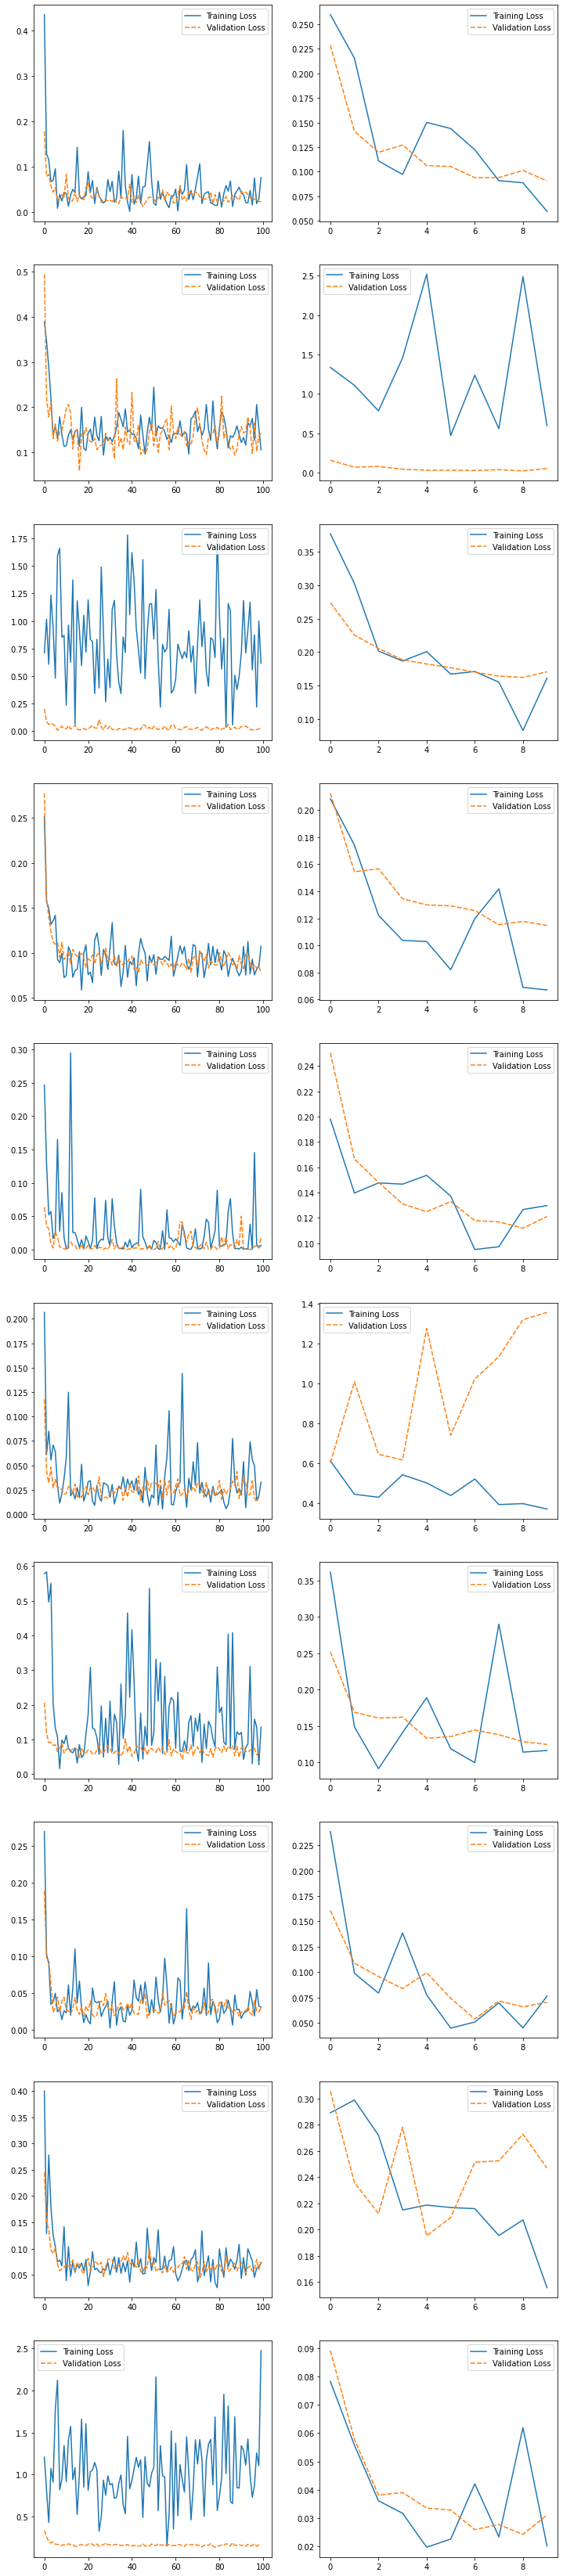

In [ ]:
plt.rcParams["figure.figsize"] = (12,6*10)
f, ax = plt.subplots(10,2)
for n in range(10):
    d1 = pd.DataFrame({"Training Loss":[np.mean(x) for x in t_train_loss[n]], 
                       "Validation Loss":[np.mean(x) for x in t_val_loss[n]]}, 
                      index=[x for x in range(100)])
    d2 = pd.DataFrame({"Training Loss":[np.mean(x) for x in p_train_loss[n]], 
                       "Validation Loss":[np.mean(x) for x in p_val_loss[n]]}, 
                      index=[x for x in range(10)])
    seaborn.lineplot(data = d1, ax=ax[n,0])
    seaborn.lineplot(data = d2, ax=ax[n,1])